<a href="https://colab.research.google.com/github/pedro-hernandez-esquivias/Programacion/blob/main/Unidad_3_Caso_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Detección de diabetes en pacientes mediante kNN**

**Resumen General**
Este cuaderno Jupyter se centra en la construcción de un modelo de aprendizaje automático utilizando el algoritmo k-Nearest Neighbors (kNN) para predecir la presencia de diabetes en pacientes, basándose en el "Pima Indians Diabetes Dataset". A través de un enfoque práctico y detallado, el cuaderno guía a los alumnos en el proceso de desarrollo de un modelo predictivo, desde la carga y exploración de datos hasta la evaluación del modelo.

**Aspectos Clave**
* **Carga y Exploración de Datos**: Se inicia con la importación de librerías necesarias y la carga del conjunto de datos. Se realiza una exploración inicial para entender la estructura y naturaleza de los datos.

* **Preparación de Datos**: Se divide el conjunto de datos en conjuntos de entrenamiento y prueba, utilizando una estratificación para mantener la proporción de las etiquetas.

* **Entrenamiento del Modelo**: Se entrena un modelo kNN con diferentes valores de K para encontrar el equilibrio óptimo entre precisión de entrenamiento y prueba.

* **Evaluación del Modelo**: Se evalúa el modelo utilizando varias métricas, incluyendo la precisión, la matriz de confusión, el informe de clasificación y la curva ROC.

* **Ajuste de Hiperparámetros**: Se utiliza GridSearchCV para el ajuste de hiperparámetros, buscando el valor óptimo de K que maximiza la precisión del modelo.

**Pasos recomendados y cuestiones**
* **Análisis Exploratorio de Datos**: ¿Podríamos profundizar más en el análisis exploratorio para entender mejor las características y su relación con la etiqueta objetivo?

* **Preprocesamiento de Datos**: ¿Sería útil aplicar técnicas de normalización o estandarización a los datos? ¿Cómo podrían estas técnicas afectar el rendimiento del modelo kNN?

* **Validación Cruzada**: ¿Podríamos emplear la validación cruzada para obtener una estimación más robusta del rendimiento del modelo?

* **Interpretación de Resultados**: ¿Cómo interpretaríamos la matriz de confusión y el informe de clasificación en términos de la capacidad del modelo para detectar casos positivos y negativos de diabetes?

* **Mejoras en el Modelo**: ¿Qué otras técnicas o algoritmos podríamos explorar para mejorar la precisión de la detección de diabetes?

* **Importancia de las Características**: ¿Cómo podríamos determinar qué características son más importantes para la predicción de la diabetes?

## 1.1 Cargar CSV de Drive

In [ ]:
# Conexión con drive para obtener el .csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Importe de librerías

In [ ]:
# Se importan las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 1.3 Exploración de los datos

In [ ]:
# Carga del dataset
df = pd.read_csv('/content/diabetes.csv')

# Hacemos un print del dataset para ver qué contiene
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [ ]:
# Qué forma tiene el dataframe
df.shape

(768, 9)

Tenemos 768 filas y 9 columnas. Las primeras 8 columnas representan las características (dimensiones) y la última columna representa el target/etiqueta.

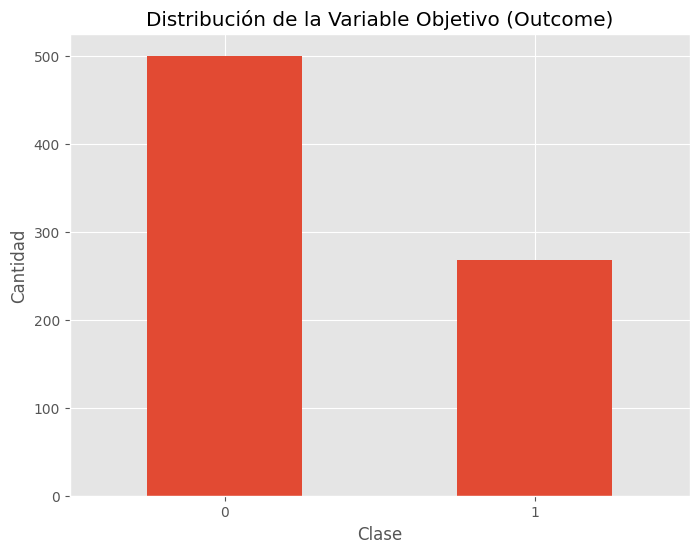

In [ ]:
# Distribución del 'Outcome'
# Conteo de las clases en la columna 'Outcome'
outcome_counts = df['Outcome'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
outcome_counts.plot(kind='bar')
plt.title('Distribución de la Variable Objetivo (Outcome)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.show()

Parece que el conjunto está desbalanceado
¿Cómo crees que afectará esto al modelo y a su precisión?
¿Qué podemos hacer para solucionarlo?

In [ ]:
# Separamos la  matriz de características en X (caracteristicas) e y (target)
X = df.drop('Outcome',axis=1).values
y = df['Outcome'].values

Vamos a dividir los datos aleatoriamente en un conjunto de entrenamiento y otro de prueba.

Ajustaremos/entrenaremos un clasificador en el conjunto de entrenamiento y haremos predicciones en el conjunto de prueba. A continuación, compararemos las predicciones con las etiquetas conocidas.

Scikit-learn ofrece la posibilidad de dividir los datos en entrenamiento y prueba utilizando el método train_test_split.

## 1.4 Separación en entrenamiento / test

In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

Es una buena práctica realizar la división de forma que refleje las etiquetas de los datos. En otras palabras, queremos que las etiquetas se dividan en los conjuntos de entrenamiento y prueba tal y como están en el conjunto de datos original. Para ello utilizamos el argumento stratify.

También creamos un conjunto de prueba de un tamaño aproximado del 40% del conjunto de datos.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=42, stratify=y)

Vamos a crear un clasificador utilizando el algoritmo k-Nearest Neighbors.

Primero observemos las precisiones para diferentes valores de k.

## 1.5 'Entrenamiento' del modelo

In [ ]:
# importamos el clasificador KNeighborsClassifier (ya se veía en los ejemplos básicos)
from sklearn.neighbors import KNeighborsClassifier

# Configuramos los arrays para almacenar las precisiones de entrenamiento y prueba
neighbors = np.arange(1,9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Iniciar el clasificador knn con k vecinos (se testea de 1 a 9)
    knn = KNeighborsClassifier(n_neighbors=k)

    # Se 'entrena' el modelo
    knn.fit(X_train, y_train)

    # Obtenemos la precisión en el conjunto de entranamiento
    train_accuracy[i] = knn.score(X_train, y_train)

    # Obtenemos la precisión en el conjunto de test
    test_accuracy[i] = knn.score(X_test, y_test)

## 1.6 Evaluación del modelo

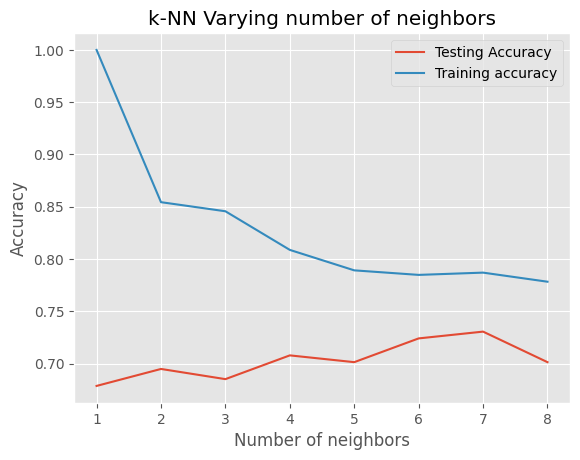

In [ ]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

Podemos observar que obtenemos la máxima precisión de prueba para k=7. Así que vamos a crear un KNeighborsClassifier con el número de vecinos como 7.

In [ ]:
# Generamos el clasificador con k = 7
knn = KNeighborsClassifier(n_neighbors=7)

In [ ]:
# Entrenamos el modelo
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

### 1.6.1 Obtención del score

In [ ]:
# Obtenemos la precisión del entrenamiento. Nota: En el caso de algoritmos de clasificación, el método de puntuación representa la precisión.
knn.score(X_test,y_test)

0.7305194805194806

### 1.6.2 **Matriz de confusión**

Una matriz de confusión es una tabla que se utiliza a menudo para describir el rendimiento de un modelo de clasificación (o "clasificador") en un conjunto de datos de prueba para los que se conocen los valores verdaderos. Scikit-learn ofrece la posibilidad de calcular la matriz de confusión utilizando el método confusion_matrix.

In [ ]:
# importamos confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
# obtengamos las predicciones utilizando el clasificador que habíamos ajustado anteriormente sobre el conjunto de test
y_pred = knn.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

array([[165,  36],
       [ 47,  60]])

Considerando la matriz de confusión anterior:

Verdadero negativo = 165

Falso positivo = 36

Verdadero positivo = 60

Falso negativo = 47

Confusion matrix can also be obtained using crosstab method of pandas.

In [ ]:
# @title Extra: crosstab
# La matriz de confusión también puede obtenerse utilizando el método crosstab de pandas.
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,165,36,201
1,47,60,107
All,212,96,308


### 1.6.3 **Informe de clasificación**

Otro informe importante es el de clasificación. Se trata de un resumen de texto de la precisión, el recall y la puntuación F1 para cada clase. Scikit-learn ofrece la posibilidad de calcular el informe de clasificación utilizando el método classification_report.

In [ ]:
#import classification_report
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       201
           1       0.62      0.56      0.59       107

    accuracy                           0.73       308
   macro avg       0.70      0.69      0.70       308
weighted avg       0.73      0.73      0.73       308



### 1.6.4 Curva ROC (Reciever Operating Charecteristic)

Es un gráfico de la tasa de verdaderos positivos frente a la tasa de falsos positivos para los distintos puntos de corte posibles de una prueba diagnóstica.

Una curva ROC demuestra varias cosas:

1) Muestra el compromiso entre sensibilidad y especificidad (cualquier aumento de la sensibilidad irá acompañado de una disminución de la especificidad).

2) Cuanto más se acerque la curva al borde izquierdo y luego al borde superior del espacio ROC, más precisa será la prueba.

3) Cuanto más se acerque la curva a la diagonal de 45 grados del espacio ROC, menos precisa será la prueba.

4) El área bajo la curva es una medida de la precisión de la prueba.

In [ ]:
y_pred_proba = knn.predict_proba(X_test)[:,1]

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

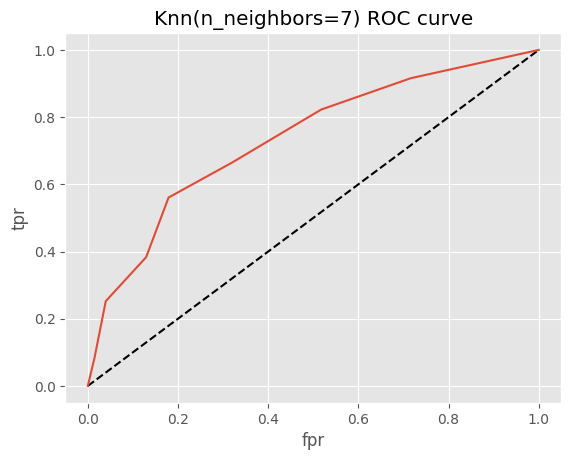

In [ ]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=7) ROC curve')
plt.show()

In [ ]:
# Curva área under ROC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.7345050448691124

## 1.7 **Cross Validation / Validación cruzada**

Antes de entrar en detalles sobre el ajuste del hiperparámetro, entendamos el concepto de validación cruzada.

El rendimiento del modelo entrenado depende de la forma en que se dividen los datos. Puede que no sea representativo de la capacidad de generalización del modelo.

La solución es la validación cruzada.

La validación cruzada es una técnica para evaluar modelos predictivos dividiendo la muestra original en un conjunto de datos de entrenamiento para entrenar el modelo y un conjunto de datos de prueba para evaluarlo.

En la validación cruzada k-fold, la muestra original se divide aleatoriamente en k submuestras del mismo tamaño. De las k submuestras, se conserva una única submuestra como datos de validación para probar el modelo, y las k-1 submuestras restantes se utilizan como datos de entrenamiento. El proceso de validación cruzada se repite k veces (los pliegues), y cada una de las k submuestras se utiliza exactamente una vez como datos de validación. Los k resultados de los pliegues pueden promediarse (o combinarse de otro modo) para obtener una única estimación. La ventaja de este método es que todas las observaciones se utilizan tanto para el entrenamiento como para la validación, y cada observación se utiliza para la validación exactamente una vez.

**Tuneo de hiperparámetros**

El valor de k (es decir, 7) que elegimos anteriormente se seleccionó observando la curva de precisión frente al número de vecinos. Ésta es una forma primitiva de ajustar los hiperparámetros.

Hay una forma mejor de hacerlo, que consiste en

1) Probar diferentes valores de hiperparámetros.

2) Ajustar todos ellos por separado

3) Comprobar el rendimiento de cada uno de ellos

4) Elegir el de mejor rendimiento

5) Utilizar siempre la validación cruzada (para cada experimento)

Scikit-learn proporciona una forma sencilla de lograr esto utilizando GridSearchCV, es decir, la validación cruzada de búsqueda de cuadrícula.



In [ ]:
# importamos GridSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
# Se introduce un rango de vecinos a estudiar
param_grid = {'n_neighbors':np.arange(1,50)}

In [ ]:
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [ ]:
knn_cv.best_score_

0.7578558696205755

In [ ]:
knn_cv.best_params_

{'n_neighbors': 14}

De lo que podemos sacar que un clasificador knn con un número de vecinos de 14 obtiene la mejor puntuación/exactitud de 0,7578, es decir, alrededor del 76% de acierto en la clasificación.